In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
mkdir checkpoints

In [3]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [4]:
# X = np.reshape(X, (-1,1,512,512))
# X.shape
# Y = np.reshape(Y, (-1,1,512,512))
# Y.shape

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [5]:
del X
del Y

In [6]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [7]:
#### Attention UNet

def conv_block(x, filter_size, size, dropout, batch_norm = False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)


def gating_signal(input, out_size, batch_norm = False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(
        inter_shape, 
        (3, 3),
        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



def Attention_UNet():
    # hyper parameters
    dropout_rate = 0.2
    batch_norm = True
    
    # network structure
    f = [16, 32, 64, 128, 256, 512, 1024]
    
    inputs = layers.Input(shape = (512, 512, 1))

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, 3, f[0], dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, 3, f[1], dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, 3, f[2], dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, 3, f[3], dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5
    conv_8 = conv_block(pool_8, 3, f[4], dropout_rate, batch_norm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(conv_8)
    # DownRes 6
    conv_4 = conv_block(pool_4, 3, f[5], dropout_rate, batch_norm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_4)
    # DownRes 7
    conv_2 = conv_block(pool_2, 3, f[6], dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 5
    gating_4 = gating_signal(conv_2, f[5], batch_norm)
    att_4 = attention_block(conv_4, gating_4, f[5])
    up_4 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(conv_2)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, 3, f[5], dropout_rate, batch_norm)
    
    # UpRes 6
    gating_8 = gating_signal(conv_4, f[4], batch_norm)
    att_8 = attention_block(conv_8, gating_8, f[4])
    up_8 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_4)
    up_8 = layers.concatenate([up_8, att_8], axis=3)
    up_conv_8 = conv_block(up_8, 3, f[4], dropout_rate, batch_norm)
    
    # UpRes 6
    gating_16 = gating_signal(up_conv_8, f[3], batch_norm)
    att_16 = attention_block(conv_16, gating_16, f[3])
    up_16 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, 3, f[3], dropout_rate, batch_norm)

    # UpRes 7
    gating_32 = gating_signal(up_conv_16, f[2], batch_norm)
    att_32 = attention_block(conv_32, gating_32, f[2])
    up_32 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, 3, f[2], dropout_rate, batch_norm)
    
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, f[1], batch_norm)
    att_64 = attention_block(conv_64, gating_64, f[1])
    up_64 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, 3, f[1], dropout_rate, batch_norm)
    
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, f[0], batch_norm)
    att_128 = attention_block(conv_128, gating_128, f[0])
    up_128 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, 3, f[0], dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis = 3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel


    # Model integration
    model = keras.models.Model(inputs, conv_final, name="Attention_UNet")
    return model

model = Attention_UNet()
model.summary()

2022-09-23 16:16:45.121533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 16:16:45.229346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 16:16:45.230147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 16:16:45.232120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [8]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [9]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [10]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

2022-09-23 16:17:04.535526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-23 16:17:13.079383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 38s 439ms/step - loss: 0.4896 - accuracy: 0.7902 - dice_coef: 0.4423 - IOU: 0.2868 - specificity: 0.8736 - recall: 0.6948 - precision: 0.6571 - val_loss: 391617.8125 - val_accuracy: 0.1633 - val_dice_coef: 0.3516 - val_IOU: 0.2135 - val_specificity: 0.0000e+00 - val_recall: 1.0000 - val_precision: 0.2477

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 16s 340ms/step - loss: 0.2978 - accuracy: 0.8733 - dice_coef: 0.5864 - IOU: 0.4154 - specificity: 0.9464 - recall: 0.8315 - precision: 0.8705 - val_loss: 3.3099 - val_accuracy: 0.6022 - val_dice_coef: 0.4480 - val_IOU: 0.2889 - val_specificity: 0.5860 - val_recall: 0.8994 - val_precision: 0.4256

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 16s 339ms/step - loss: 0.2310 - accuracy: 0.8813 - dice_coef: 0.6566 - IOU: 0.4893 - specificity: 0.9597 - recall: 0.8163 - precision: 0.9026 - val_loss: 0.5514

In [11]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [12]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.489583,0.790205,0.442262,0.286782,0.873609,0.694842,0.657081,391617.812500,0.163279,0.351580,0.213542,0.000000,1.000000,0.247733,0.01
1,0.297756,0.873290,0.586377,0.415430,0.946409,0.831485,0.870521,3.309942,0.602223,0.447989,0.288950,0.586035,0.899380,0.425611,0.01
2,0.230965,0.881324,0.656555,0.489259,0.959657,0.816305,0.902649,0.551356,0.758460,0.182888,0.100756,0.998903,0.036232,0.938467,0.01
3,0.197777,0.884082,0.698096,0.536511,0.964882,0.806085,0.915961,0.628903,0.752279,0.103371,0.054504,1.000000,0.000064,1.000000,0.01
4,0.172833,0.887852,0.732116,0.577618,0.970170,0.804116,0.930012,0.613535,0.752296,0.111495,0.059041,1.000000,0.000159,1.000000,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.043385,0.914272,0.936243,0.880137,0.993745,0.860559,0.992431,0.188516,0.895548,0.884868,0.794331,0.988450,0.783188,0.982344,0.01
136,0.040574,0.914956,0.940269,0.887276,0.994412,0.862620,0.993933,0.081147,0.906856,0.921935,0.855294,0.989702,0.841394,0.985313,0.01
137,0.039340,0.915223,0.942254,0.890816,0.994832,0.862583,0.994600,0.087644,0.905712,0.916407,0.845848,0.989922,0.834108,0.986051,0.01
138,0.038704,0.915358,0.943016,0.892182,0.995069,0.862206,0.994974,0.139733,0.899474,0.895321,0.811031,0.991434,0.787906,0.986990,0.01


In [13]:
idx = hist_df['val_accuracy'].idxmax()
print(idx, hist_df['val_accuracy'][idx])

119 0.9079405069351196


In [14]:
model.save('attn_unet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
pred = model.predict(X_test)

In [16]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9786795339276714

In [17]:
pred.shape

(93, 512, 512, 1)

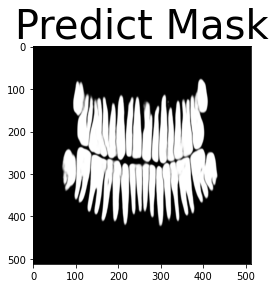

In [18]:
# plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

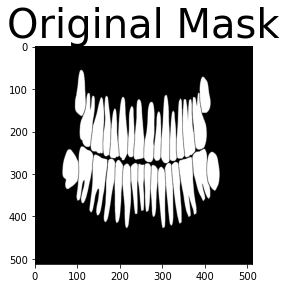

In [19]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')
